<a href="https://colab.research.google.com/github/zzeng507/sec-financial-analysis/blob/main/SEC-Financial-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===== Cell 0: Setup =====
!pip -q install yfinance scikit-learn

import re, time, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

plt.rcParams["figure.figsize"] = (8,4)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

YOUR_NAME  = "ZIQI_ZENG"
YOUR_EMAIL = "zzeng507@gmail.com"

SEC_HEADERS = {
    "User-Agent": f"{YOUR_NAME} {YOUR_EMAIL}",
    "Accept-Encoding": "gzip, deflate",
    "Accept": "application/json",
    "Host": "data.sec.gov",
}


In [ ]:
# ===== Cell 1: Tickers & CIKs =====
TICKERS = ["TSLA", "NVDA", "F"]
YEARS_WINDOW = 5

FALLBACK_CIKS = {
    "TSLA":"0001318605","NVDA":"0001045810","F":"0000037996",
    "WMT":"0000104169","COST":"0000909832","TGT":"0000027419",
    "AAPL":"0000320193","MSFT":"0000789019","GM":"0000040730"
}
CIKS = {t: FALLBACK_CIKS[t] for t in TICKERS}
CIKS


{'TSLA': '0001318605', 'NVDA': '0001045810', 'F': '0000037996'}

In [ ]:
# ===== Cell 2: EDGAR helpers =====
ANNUAL_FORMS = {"10-K","10-K/A","20-F","20-F/A"}
BASE_FACTS   = "https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"

EXCLUDE_PATTERNS = [
    r"DeferredRevenue", r"ContractWithCustomer", r"RevenueRecognized",
    r"IncreaseDecreaseInDeferredRevenue", r"ProFormaRevenue",
    r"Geographic.*Revenue", r"Regulated.*Revenue"
]
_exclude_re = re.compile("|".join(EXCLUDE_PATTERNS), re.I)

def fetch_companyfacts(cik: str) -> dict:
    time.sleep(0.25)  # be nice to SEC
    r = requests.get(BASE_FACTS.format(cik=cik), headers=SEC_HEADERS, timeout=60)
    r.raise_for_status()
    return r.json()

def infer_year(rec: dict):
    if rec.get("fy"): return int(rec["fy"])
    frame = rec.get("frame") or ""
    m = re.search(r"(?:FY|CY)?(\d{4})", frame)
    if m: return int(m.group(1))
    end = rec.get("end") or ""
    if len(end) >= 4 and end[:4].isdigit(): return int(end[:4])
    return None

def pick_records(records):
    items=[]
    for r in records:
        fy = infer_year(r)
        if fy and (r.get("val") is not None):
            rr = dict(r); rr["fy"] = fy
            items.append(rr)
    if not items: return []
    best={}
    for r in items:
        fy = int(r["fy"]); form=r.get("form"); end=r.get("end") or ""
        score = (1 if form in ANNUAL_FORMS else 0, end)
        if (fy not in best) or (score > best[fy]["_score"]):
            best[fy] = {"fy":fy,"val":float(r["val"]), "form":form, "end":end, "_score":score}
    return sorted([{"fy":v["fy"],"val":v["val"],"form":v["form"],"end":v["end"]} for v in best.values()],
                  key=lambda x:x["fy"])

def extract_units_generic(units_dict):
    if "USD" in units_dict: return pick_records(units_dict["USD"])
    for _, v in units_dict.items():
        if isinstance(v, list): return pick_records(v)
    return None

def autodetect_revenue_key(facts: dict):
    best_key, best_recs = None, []
    usgaap = facts.get("facts", {}).get("us-gaap", {})
    for key, detail in usgaap.items():
        name = str(key)
        if (("Revenue" in name) or ("Sales" in name)) and (not _exclude_re.search(name)):
            recs = extract_units_generic(detail.get("units", {})) or []
            if len(recs) > len(best_recs):
                best_recs, best_key = recs, name
    return best_key, best_recs


In [ ]:
# ===== Cell 3: Keys & extraction =====
CORE_KEYS = {
    "Revenue":            ("auto","Revenue"),  # placeholder (filled by override/autodetect)
    "NetIncome":          ("us-gaap","NetIncomeLoss"),
    "Assets":             ("us-gaap","Assets"),
    "Liabilities":        ("us-gaap","Liabilities"),
    "Equity":             ("us-gaap","StockholdersEquity"),
    "CurrentAssets":      ("us-gaap","AssetsCurrent"),
    "CurrentLiabilities": ("us-gaap","LiabilitiesCurrent"),
    "GrossProfit":        ("us-gaap","GrossProfit"),
}

ADV_KEYS = {
    "CFO": [
        ("us-gaap","NetCashProvidedByUsedInOperatingActivities"),
        ("us-gaap","NetCashProvidedByUsedInOperatingActivitiesContinuingOperations"),
    ],
    "CapEx": [
        ("us-gaap","PaymentsToAcquirePropertyPlantAndEquipment"),
        ("us-gaap","CapitalExpenditures"),
    ],
    "OperatingIncome": [("us-gaap","OperatingIncomeLoss")],
    "DepAmort": [
        ("us-gaap","DepreciationAndAmortization"),
        ("us-gaap","DepreciationDepletionAndAmortization"),
    ],
    "InterestExpense": [("us-gaap","InterestExpense")],
    "IncomeTaxExpense": [("us-gaap","IncomeTaxExpenseBenefit")],
    "DilutedShares": [
        ("us-gaap","WeightedAverageNumberOfDilutedSharesOutstanding"),
        ("us-gaap","CommonStockSharesOutstanding")
    ]
}

def extract_first_available(facts: dict, candidates: list):
    for ns, key in candidates:
        detail = facts.get("facts",{}).get(ns,{}).get(key)
        if not detail:
            continue
        recs = extract_units_generic(detail.get("units", {})) or []
        if recs:
            return recs, f"{ns}:{key}"
    return [], None

# --- Revenue override to avoid CostOfRevenue, etc. ---
REVENUE_KEY_OVERRIDE = {
    "TSLA": ["Revenues", "SalesRevenueNet", "RevenueFromContractWithCustomerExcludingAssessedTax"],
    "F":    ["Revenues", "SalesRevenueNet"],
    "NVDA": ["Revenues", "SalesRevenueNet"],
}

def get_revenue_series_with_override(ticker: str, cik: str, facts: dict):
    if ticker in REVENUE_KEY_OVERRIDE:
        for key in REVENUE_KEY_OVERRIDE[ticker]:
            detail = facts.get("facts",{}).get("us-gaap",{}).get(key)
            if not detail: continue
            recs = extract_units_generic(detail.get("units", {})) or []
            if recs: return recs, f"us-gaap:{key}"
    # fallback: autodetect
    k_auto, recs_auto = autodetect_revenue_key(facts)
    if k_auto and recs_auto: return recs_auto, f"us-gaap:{k_auto}"
    return [], None

def get_financials(ticker: str, cik: str):
    facts = fetch_companyfacts(cik)
    rows={}
    chosen = {}

    # Revenue
    rev_recs, rev_key = get_revenue_series_with_override(ticker, cik, facts)
    if rev_recs:
        chosen["Revenue"] = rev_key
        for r in rev_recs:
            fy, val = r["fy"], r["val"]
            rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
            rows[fy]["Revenue"] = val

    # Core metrics
    for m,(ns2,k2) in CORE_KEYS.items():
        if ns2 == "auto":  # skip placeholder
            continue
        detail = facts.get("facts",{}).get(ns2,{}).get(k2)
        if not detail:
            continue
        recs = extract_units_generic(detail.get("units", {})) or []
        for r in recs:
            fy, val = r["fy"], r["val"]
            rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
            rows[fy][m] = val

    # Advanced
    for m, cand in ADV_KEYS.items():
        recs, used_key = extract_first_available(facts, cand)
        if recs:
            chosen[m] = used_key
            for r in recs:
                fy, val = r["fy"], r["val"]
                rows.setdefault(fy, {"Ticker": ticker, "Year": fy})
                rows[fy][m] = val

    df = pd.DataFrame(list(rows.values())).sort_values("Year") if rows else pd.DataFrame()
    return df, chosen


In [ ]:
# ===== Cell 4: Build dataset =====
frames, chosen_map = [], {}
for t in TICKERS:
    df_t, chosen = get_financials(t, CIKS[t])
    df_t["Ticker"] = t
    frames.append(df_t)
    chosen_map[t] = chosen

raw_df = pd.concat(frames, ignore_index=True)
max_year = int(raw_df["Year"].max())
keep_years = list(range(max_year - YEARS_WINDOW + 1, max_year + 1))
raw_df = raw_df[raw_df["Year"].isin(keep_years)].sort_values(["Ticker","Year"]).reset_index(drop=True)

print("Chosen revenue keys:")
for k,v in chosen_map.items():
    print(k, "→", v.get("Revenue"))
display(raw_df.head(12))


Chosen revenue keys:
TSLA → us-gaap:Revenues
NVDA → us-gaap:Revenues
F → us-gaap:Revenues


,Ticker,Year,Revenue,NetIncome,Assets,Liabilities,Equity,CurrentAssets,CurrentLiabilities,GrossProfit,CFO,CapEx,OperatingIncome,DepAmort,InterestExpense,IncomeTaxExpense,DilutedShares
0,F,2022,"158,057,000,000.00",NaN,"255,884,000,000.00","212,717,000,000.00","43,242,000,000.00","116,476,000,000.00","96,866,000,000.00",NaN,"6,853,000,000.00",NaN,"6,276,000,000.00","7,674,000,000.00","4,593,000,000.00","-864,000,000.00","4,014,000,000.00"
1,F,2023,"176,191,000,000.00","4,347,000,000.00","273,310,000,000.00","230,512,000,000.00","42,773,000,000.00","121,481,000,000.00","101,531,000,000.00",NaN,"14,918,000,000.00",NaN,"5,458,000,000.00","7,690,000,000.00","7,613,000,000.00","-362,000,000.00","4,041,000,000.00"
2,F,2024,"184,992,000,000.00","5,879,000,000.00","285,196,000,000.00","240,338,000,000.00","44,835,000,000.00","124,474,000,000.00","106,859,000,000.00",NaN,"15,423,000,000.00",NaN,"5,219,000,000.00","7,567,000,000.00",NaN,"1,339,000,000.00","4,021,000,000.00"
3,F,2025,NaN,"-36,000,000.00","292,725,000,000.00","247,644,000,000.00","45,057,000,000.00","126,612,000,000.00","114,988,000,000.00",NaN,"9,996,000,000.00",NaN,"830,000,000.00","3,747,000,000.00",NaN,"718,000,000.00","4,018,000,000.00"
4,NVDA,2022,"26,914,000,000.00","9,752,000,000.00","44,187,000,000.00","17,575,000,000.00","26,612,000,000.00","28,829,000,000.00","4,335,000,000.00","17,475,000,000.00","9,108,000,000.00",NaN,"10,041,000,000.00","567,000,000.00","236,000,000.00","189,000,000.00","2,535,000,000.00"
5,NVDA,2023,"26,974,000,000.00","4,368,000,000.00","41,182,000,000.00","19,081,000,000.00","22,101,000,000.00","23,073,000,000.00","6,563,000,000.00","15,356,000,000.00","5,641,000,000.00",NaN,"4,224,000,000.00",NaN,"262,000,000.00","-187,000,000.00","2,507,000,000.00"
6,NVDA,2024,"60,922,000,000.00","29,760,000,000.00","65,728,000,000.00","22,750,000,000.00","42,978,000,000.00","44,345,000,000.00","10,631,000,000.00","44,301,000,000.00","28,090,000,000.00",NaN,"32,972,000,000.00",NaN,"257,000,000.00","4,058,000,000.00","2,494,000,000.00"
7,NVDA,2025,"130,497,000,000.00","72,880,000,000.00","111,601,000,000.00","32,274,000,000.00","79,327,000,000.00","80,126,000,000.00","18,047,000,000.00","97,858,000,000.00","64,089,000,000.00",NaN,"81,453,000,000.00",NaN,"64,000,000.00","11,146,000,000.00","24,804,000,000.00"
8,NVDA,2026,"90,805,000,000.00","45,197,000,000.00","140,740,000,000.00","40,609,000,000.00","100,131,000,000.00","102,219,000,000.00","24,257,000,000.00","60,521,000,000.00","42,779,000,000.00",NaN,"50,078,000,000.00",NaN,NaN,"7,920,000,000.00","24,571,000,000.00"
9,TSLA,2022,"81,462,000,000.00","12,556,000,000.00","82,338,000,000.00","36,440,000,000.00","44,704,000,000.00","40,917,000,000.00","26,709,000,000.00","20,853,000,000.00","14,724,000,000.00","7,158,000,000.00","13,656,000,000.00",NaN,"191,000,000.00","1,132,000,000.00","3,475,000,000.00"


In [ ]:
# ===== Cell 5: Metrics, Forecast, Robust Valuation =====
def compute_ratios_advanced(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    eps = 1e-9
    df["ROE"] = df["NetIncome"] / (df["Equity"] + eps)
    df["ROA"] = df["NetIncome"] / (df["Assets"] + eps)
    df["DebtToEquity"]  = df["Liabilities"] / (df["Equity"] + eps)
    df["CurrentRatio"]  = df["CurrentAssets"] / (df["CurrentLiabilities"] + eps)
    df["GrossMargin"]   = df.get("GrossProfit", np.nan) / (df.get("Revenue", np.nan) + eps)
    df["NetMargin"]     = df["NetIncome"] / (df["Revenue"] + eps)

    df["RevenueGrowth"]   = df.groupby("Ticker")["Revenue"].pct_change()
    df["NetIncomeGrowth"] = df.groupby("Ticker")["NetIncome"].pct_change()

    df["EBITDA"] = np.where(
        df.get("OperatingIncome", pd.Series([np.nan]*len(df))).notna() &
        df.get("DepAmort", pd.Series([np.nan]*len(df))).notna(),
        df["OperatingIncome"] + df["DepAmort"],
        df.get("NetIncome", 0).fillna(0)
        + df.get("IncomeTaxExpense", 0).fillna(0)
        + df.get("InterestExpense", 0).fillna(0)
        + df.get("DepAmort", 0).fillna(0)
    )
    df["EBITDA_Margin"] = df["EBITDA"] / (df["Revenue"] + eps)

    df["FCF"] = df.get("CFO", np.nan) - df.get("CapEx", np.nan)
    df["FCF_Margin"] = df["FCF"] / (df["Revenue"] + eps)

    def _cagr(s):
        s = s.dropna()
        if len(s) < 2: return np.nan
        return (s.iloc[-1] / (s.iloc[0] + eps))**(1/(len(s)-1)) - 1
    df["RevenueCAGR_5Y"] = df.groupby("Ticker")["Revenue"].transform(_cagr)
    return df

def forecast_revenue_linear(df: pd.DataFrame, years_ahead=2):
    forecasts=[]
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].dropna(subset=["Revenue"]).sort_values("Year")
        if len(sub) < 2: continue
        X = sub["Year"].values.reshape(-1,1)
        y = sub["Revenue"].values
        model = LinearRegression().fit(X, y)
        last_year = int(sub["Year"].max())
        for k in range(1, years_ahead+1):
            y_hat = model.predict(np.array([[last_year + k]]))[0]
            forecasts.append({"Ticker": t, "Year": last_year+k, "Revenue_Forecast": float(y_hat)})
    return pd.DataFrame(forecasts)

def analyze_valuation_robust(metrics_df: pd.DataFrame) -> pd.DataFrame:
    rows=[]
    for t in metrics_df["Ticker"].unique():
        sub = metrics_df[metrics_df["Ticker"]==t].dropna(subset=["NetIncome","DilutedShares"]).sort_values("Year")
        if sub.empty:
            rows.append({"Ticker":t,"Price":np.nan,"EPS_TTM":np.nan,"PE":np.nan});
            continue
        last = sub.iloc[-1]
        eps_ttm = last["NetIncome"] / (last["DilutedShares"] + 1e-9)
        try:
            price = yf.Ticker(t).history(period="5d")["Close"].iloc[-1]
        except Exception:
            price = np.nan
        pe = price / (eps_ttm + 1e-9) if pd.notna(price) else np.nan
        rows.append({"Ticker":t,"Price":float(price) if pd.notna(price) else np.nan,
                    "EPS_TTM": float(eps_ttm), "PE": float(pe) if pd.notna(pe) else np.nan})
    pe_df = pd.DataFrame(rows)

    cagr = metrics_df.groupby("Ticker")["RevenueCAGR_5Y"].last().reset_index()
    val = pe_df.merge(cagr, on="Ticker", how="left")

    val["PEG"] = np.where(
        (val["PE"]>0) & (val["RevenueCAGR_5Y"]>0),
        val["PE"] / (val["RevenueCAGR_5Y"] + 1e-9),
        np.nan
    )

    def _reason(row):
        if pd.isna(row["PE"]) or pd.isna(row["RevenueCAGR_5Y"]): return "missing"
        if row["PE"]<=0: return "negative PE"
        if row["RevenueCAGR_5Y"]<=0: return "non-positive CAGR"
        return ""
    val["PEG_note"] = val.apply(_reason, axis=1)
    return val[["Ticker","PE","RevenueCAGR_5Y","PEG","PEG_note"]].sort_values(["PEG_note","PEG"], na_position="last")

# run pipeline
metrics_df = compute_ratios_advanced(raw_df)
fcst_df    = forecast_revenue_linear(metrics_df, years_ahead=2)
peg_table  = analyze_valuation_robust(metrics_df)

display(metrics_df.head(12))
display(peg_table)


/tmp/ipython-input-66735892.py:12: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["RevenueGrowth"]   = df.groupby("Ticker")["Revenue"].pct_change()
/tmp/ipython-input-66735892.py:13: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["NetIncomeGrowth"] = df.groupby("Ticker")["NetIncome"].pct_change()


,Ticker,Year,Revenue,NetIncome,Assets,Liabilities,Equity,CurrentAssets,CurrentLiabilities,GrossProfit,...,CurrentRatio,GrossMargin,NetMargin,RevenueGrowth,NetIncomeGrowth,EBITDA,EBITDA_Margin,FCF,FCF_Margin,RevenueCAGR_5Y
0,F,2022,"158,057,000,000.00",NaN,"255,884,000,000.00","212,717,000,000.00","43,242,000,000.00","116,476,000,000.00","96,866,000,000.00",NaN,...,1.20,NaN,NaN,NaN,NaN,"13,950,000,000.00",0.09,NaN,NaN,0.08
1,F,2023,"176,191,000,000.00","4,347,000,000.00","273,310,000,000.00","230,512,000,000.00","42,773,000,000.00","121,481,000,000.00","101,531,000,000.00",NaN,...,1.20,NaN,0.02,0.11,NaN,"13,148,000,000.00",0.07,NaN,NaN,0.08
2,F,2024,"184,992,000,000.00","5,879,000,000.00","285,196,000,000.00","240,338,000,000.00","44,835,000,000.00","124,474,000,000.00","106,859,000,000.00",NaN,...,1.16,NaN,0.03,0.05,0.35,"12,786,000,000.00",0.07,NaN,NaN,0.08
3,F,2025,NaN,"-36,000,000.00","292,725,000,000.00","247,644,000,000.00","45,057,000,000.00","126,612,000,000.00","114,988,000,000.00",NaN,...,1.10,NaN,NaN,0.00,-1.01,"4,577,000,000.00",NaN,NaN,NaN,0.08
4,NVDA,2022,"26,914,000,000.00","9,752,000,000.00","44,187,000,000.00","17,575,000,000.00","26,612,000,000.00","28,829,000,000.00","4,335,000,000.00","17,475,000,000.00",...,6.65,0.65,0.36,NaN,NaN,"10,608,000,000.00",0.39,NaN,NaN,0.36
5,NVDA,2023,"26,974,000,000.00","4,368,000,000.00","41,182,000,000.00","19,081,000,000.00","22,101,000,000.00","23,073,000,000.00","6,563,000,000.00","15,356,000,000.00",...,3.52,0.57,0.16,0.00,-0.55,"4,443,000,000.00",0.16,NaN,NaN,0.36
6,NVDA,2024,"60,922,000,000.00","29,760,000,000.00","65,728,000,000.00","22,750,000,000.00","42,978,000,000.00","44,345,000,000.00","10,631,000,000.00","44,301,000,000.00",...,4.17,0.73,0.49,1.26,5.81,"34,075,000,000.00",0.56,NaN,NaN,0.36
7,NVDA,2025,"130,497,000,000.00","72,880,000,000.00","111,601,000,000.00","32,274,000,000.00","79,327,000,000.00","80,126,000,000.00","18,047,000,000.00","97,858,000,000.00",...,4.44,0.75,0.56,1.14,1.45,"84,090,000,000.00",0.64,NaN,NaN,0.36
8,NVDA,2026,"90,805,000,000.00","45,197,000,000.00","140,740,000,000.00","40,609,000,000.00","100,131,000,000.00","102,219,000,000.00","24,257,000,000.00","60,521,000,000.00",...,4.21,0.67,0.50,-0.30,-0.38,"53,117,000,000.00",0.58,NaN,NaN,0.36
9,TSLA,2022,"81,462,000,000.00","12,556,000,000.00","82,338,000,000.00","36,440,000,000.00","44,704,000,000.00","40,917,000,000.00","26,709,000,000.00","20,853,000,000.00",...,1.53,0.26,0.15,NaN,NaN,"13,879,000,000.00",0.17,"7,566,000,000.00",0.09,-0.20


,Ticker,PE,RevenueCAGR_5Y,PEG,PEG_note
1,NVDA,95.07,0.36,267.59,
0,F,"-1,295.81",0.08,NaN,negative PE
2,TSLA,938.71,-0.20,NaN,non-positive CAGR


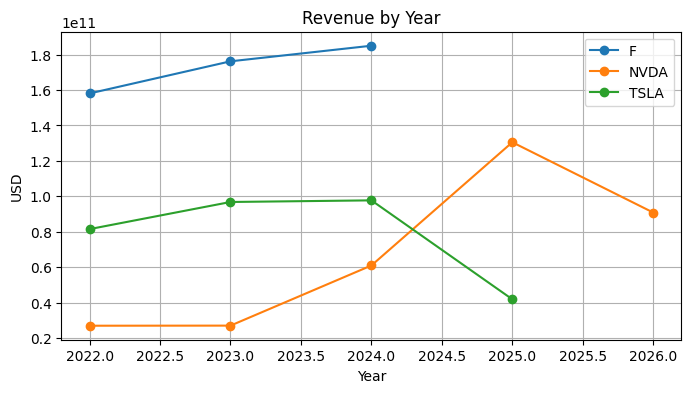

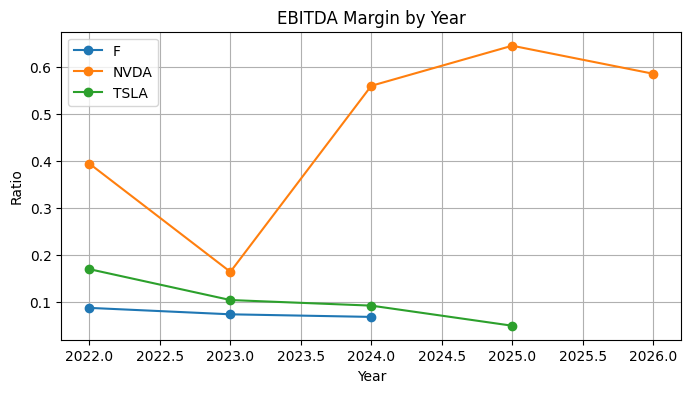

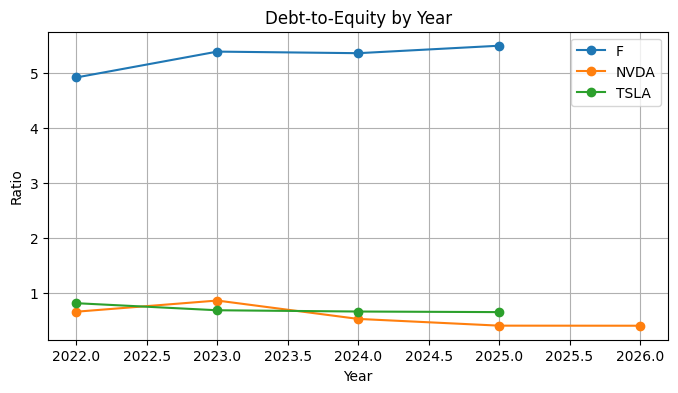

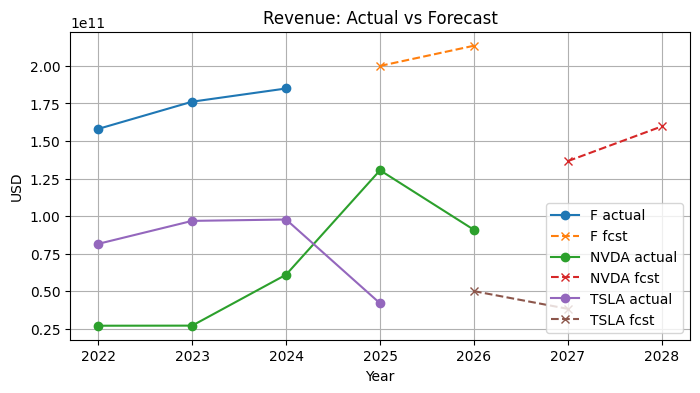

Saved: /content/sec_financials_clean.csv


In [ ]:
# ===== Cell 6: Plots & Export =====
def plot_metric(df, metric, ylabel=None, title=None):
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        plt.plot(sub["Year"], sub[metric], marker="o", label=t)
    plt.legend(); plt.xlabel("Year"); plt.ylabel(ylabel or metric)
    if title: plt.title(title)
    plt.grid(True); plt.show()

def plot_revenue_with_forecast(df, fcst):
    for t in df["Ticker"].unique():
        sub = df[df["Ticker"]==t].sort_values("Year")
        plt.plot(sub["Year"], sub["Revenue"], marker="o", label=f"{t} actual")
        subf = fcst[fcst["Ticker"]==t]
        if len(subf):
            plt.plot(subf["Year"], subf["Revenue_Forecast"], marker="x", linestyle="--", label=f"{t} fcst")
    plt.legend(); plt.xlabel("Year"); plt.ylabel("USD")
    plt.title("Revenue: Actual vs Forecast"); plt.grid(True); plt.show()

plot_metric(metrics_df, "Revenue", "USD", "Revenue by Year")
plot_metric(metrics_df, "EBITDA_Margin", "Ratio", "EBITDA Margin by Year")
plot_metric(metrics_df, "DebtToEquity", "Ratio", "Debt-to-Equity by Year")
plot_revenue_with_forecast(metrics_df, fcst_df)

out_csv = "/content/sec_financials_clean.csv"
metrics_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


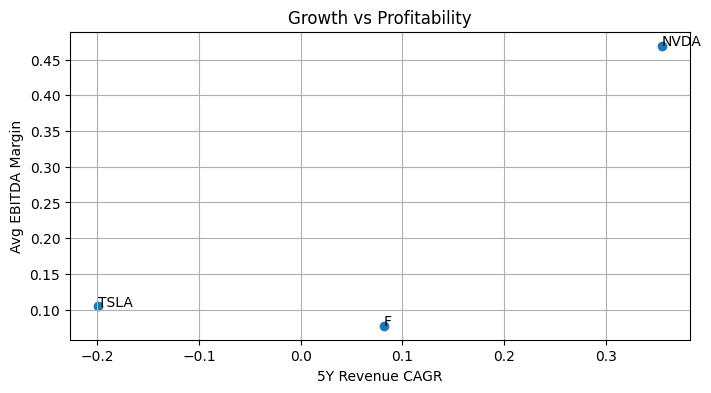

,Ticker,RevenueCAGR_5Y,EBITDA_Margin
0,F,0.08,0.08
1,NVDA,0.36,0.47
2,TSLA,-0.20,0.10


Cash Flow Sustainability: not enough data for the latest FY — skipping plot.


,Ticker,CFO,CapEx,Revenue,FCF,FCF_Margin,CapExIntensity
8,NVDA,"42,779,000,000.00",NaN,"90,805,000,000.00",NaN,NaN,NaN


In [ ]:
# ===== Cell 7 (robust, EN-only): Question-driven analyses =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 7A — Growth vs Profitability
def analyze_tradeoff(df: pd.DataFrame) -> pd.DataFrame:
    trade = df.groupby("Ticker").agg(
        RevenueCAGR_5Y=("RevenueCAGR_5Y", "last"),
        EBITDA_Margin=("EBITDA_Margin", "mean"),
    ).reset_index()

    valid = trade.dropna(subset=["RevenueCAGR_5Y", "EBITDA_Margin"])
    if len(valid) >= 2:
        plt.figure()
        plt.scatter(valid["RevenueCAGR_5Y"], valid["EBITDA_Margin"])
        for _, r in valid.iterrows():
            plt.text(r["RevenueCAGR_5Y"], r["EBITDA_Margin"], r["Ticker"])
        plt.xlabel("5Y Revenue CAGR")
        plt.ylabel("Avg EBITDA Margin")
        plt.title("Growth vs Profitability")
        plt.grid(True)
        plt.show()
    else:
        print("Trade-off: not enough valid points to plot.")

    return trade


trade_df = analyze_tradeoff(metrics_df)
display(trade_df)


# 7C — Cash Flow Sustainability (skip plotting if data is insufficient)
def analyze_cashflow_sustainability(df: pd.DataFrame, min_points: int = 2) -> pd.DataFrame:
    latest_year = df["Year"].max()
    sub = df[df["Year"] == latest_year].copy()

    cols_needed = ["Ticker", "CFO", "CapEx", "Revenue"]
    have = sub.dropna(subset=cols_needed).copy()

    if have.empty or len(have) < min_points:
        print("Cash Flow Sustainability: not enough data for the latest FY — skipping plot.")
        out = sub[["Ticker", "CFO", "CapEx", "Revenue"]].copy()
        out["FCF"] = np.nan
        out["FCF_Margin"] = np.nan
        out["CapExIntensity"] = np.nan
        return out

    eps = 1e-9
    have["FCF"] = have["CFO"] - have["CapEx"]
    have["FCF_Margin"] = have["FCF"] / (have["Revenue"] + eps)
    have["CapExIntensity"] = have["CapEx"] / (have["Revenue"] + eps)

    plt.figure()
    plt.scatter(have["CapExIntensity"], have["FCF_Margin"])
    for _, r in have.iterrows():
        plt.text(r["CapExIntensity"], r["FCF_Margin"], r["Ticker"])
    plt.xlabel("CapEx / Revenue")
    plt.ylabel("FCF Margin")
    plt.title("Cash Flow Sustainability")
    plt.grid(True)
    plt.show()

    return have[["Ticker", "FCF", "Revenue", "FCF_Margin", "CapEx", "CapExIntensity"]].sort_values(
        "FCF_Margin", ascending=False
    )


cash_df = analyze_cashflow_sustainability(metrics_df)
display(cash_df)
